In [2]:
import math
from math import cos, sin, log, log10, pi
from decimal import Decimal as D
import numpy as np
from matplotlib import pyplot as plt
pi, math.e

(3.141592653589793, 2.718281828459045)

In [3]:
import time as tt
from datetime import datetime

def asHoursMins(s):
    h = math.floor(s / 3600)
    s -= h * 3600
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dh %2dm %2ds' % (h, m, s)

# For the use of decorator, refer to the following two links:
#
# https://medium.com/citycoddee/python%E9%80%B2%E9%9A%8E%E6%8A%80%E5%B7%A7-3-%E7%A5%9E%E5%A5%87%E5%8F%88%E7%BE%8E%E5%A5%BD%E7%9A%84-decorator-%E5%97%B7%E5%97%9A-6559edc87bc0
# https://dev.to/apcelent/python-decorator-tutorial-with-example-529f

class code_timer:
    def __init__(self, func):
        self.code_func = func
        self.code_name = func.__name__
        
    def __call__(self, *args, **kwargs):
        start_time = datetime.fromtimestamp(tt.time())
        print('Begin running %s at %s ...'%\
              (self.code_name, start_time.strftime("%Y-%m-%d %H:%M:%S")))
        result = self.code_func(*args, **kwargs)
        stop_time = datetime.fromtimestamp(tt.time())
        train_time = (stop_time - start_time).total_seconds()
        print('Done running at %s!'%\
              (stop_time.strftime("%Y-%m-%d %H:%M:%S")))
        print('Total running time : %s'%(asHoursMins(train_time)))
        return result

### Check Two Particles in 3D Space with Sun and Earth Motion Data

In [4]:
# setting
mass_sun = 1.9891e30
mass_earth = mass_sun / 332946.
mass = (mass_sun * mass_earth) / (mass_sun + mass_earth)
G = 6.67384e-11
fac_GMm = G * mass_sun * mass_earth    # the factor for gravitational system of sun and earth
fac = fac_GMm


AU = 1.495978707e11
day = 60. * 60. * 24

T_max = 365. * day
dt = .001 * day
t = 0.0

# fac = 1  # the factor for testing circular motion
# mass = 1.
# T_max = 10.
# dt = 0.001
# t = 0.
decimal_place = [-1, -8]  # Define the range of decimal place

In [5]:
# The unit of velocity is AU / day
x, y, z = map(lambda x: x * AU, (1.160148e-1, -9.266055e-1, -4.018062e-1))
vx, vy, vz = map(lambda x: x * AU / day, (1.681162e-2, 1.743130e-3, 7.599750e-4))  
earth_x = (x, y, z)
earth_v = (vx, vy, vz)

In [6]:
# Consider gravitation and in 3D space
def force(x, y, z):
    r = (x * x + y * y + z * z)**0.5
    f = -1 * fac / (r**3)
    fx = f * x
    fy = f * y
    fz = f * z
    return fx, fy, fz

In [7]:
# Gravitational potential in 3D space
def potential(x, y, z):
    r = (x * x + y * y + z * z)**0.5
    p = -1 * fac / r
    return p

In [8]:
# Kinetic energy in 3D space
def kinetic_energy(m, vx, vy, vz):
    k = 0.5 * m * (vx * vx + vy * vy + vz * vz)
    return k

In [9]:
def varlet_velocity_3D(t=0.0, x=1.0, y=0.0, z=0.0,\
                       vx=0.0, vy=0.0, vz=0.0,\
                       dt=0.001, t_final=T_max, m=mass, force=force):
    # Must ensure it can run single step calculation.
    # That is, when t = t_0, t_final = t_0 + dt, the result must be correct.
    
    x_lst = []
    v_lst = []
    x_lst.append((x, y ,z))
    v_lst.append((vx, vy, vz))
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    # Warning 1: never use np.arange to iterate over float steps
    # because sometimes it will abnormaly include stop condition,
    # which is the result that we do not want it happen.
    #
    # Warning 2: even if you add step size to time iteratively,
    # there is still an inherent error, i.e. floating-point approximation
    # error, which is due to the non-exact representation from
    # the binary floating point standard(IEEE-754). The workaround
    # is to use the decimal.Decimal(str(float_number)) in iteration.
    
    while (time < t_final):
        time += dt_t
        fx, fy, fz = force(x, y, z)
        vx, vy, vz = map(lambda f, v : v + f / (2 * m) * dt, (fx, fy, fz), (vx, vy, vz))
        x, y, z = map(lambda x, v : x + v * dt, (x, y, z), (vx, vy, vz))
        fx, fy, fz = force(x, y, z)
        vx, vy, vz = map(lambda f, v : v + f / (2 * m) * dt, (fx, fy, fz), (vx, vy, vz))
#         print(dt, (x, y, z), (vx, vy, vz))
        x_lst.append((x, y, z))
        v_lst.append((vx, vy, vz))
    return x_lst, v_lst

In [10]:
x_lst, v_lst = varlet_velocity_3D(x=earth_x[0], y=earth_x[1], z=earth_x[2],\
                                  vx=earth_v[0], vy=earth_v[1], vz=earth_v[2],\
                                  m=mass_earth, dt=dt, force=force)
len(x_lst)

365001

In [11]:
x_, y_, z_ = zip(*x_lst)
vx_, vy_, vz_ = zip(*v_lst)
x_, y_, z_ = map(lambda a: [i / AU for i in a], (x_, y_, z_))

In [12]:
len(x_), len(y_), len(z_)

(365001, 365001, 365001)

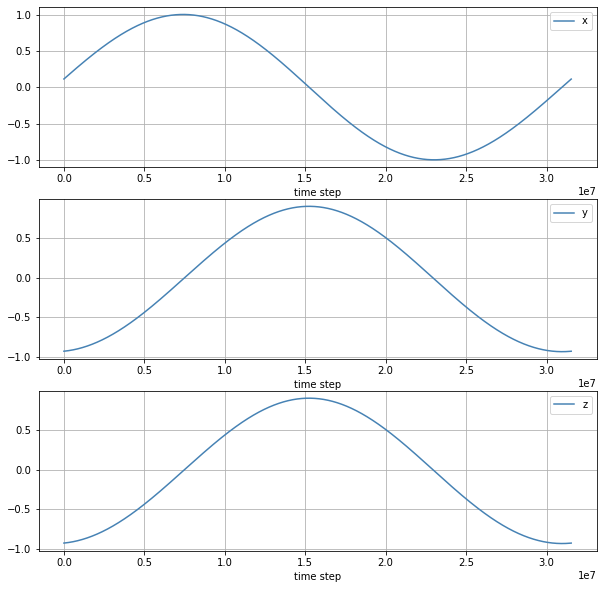

In [13]:
fig, ax1 = plt.subplots(3, 1, figsize=(10, 10))
ax1[0].set_xlabel('time step')
ax1[1].set_xlabel('time step')
ax1[2].set_xlabel('time step')
# ax1.set_ylabel('position', color='b')
x__, = ax1[0].plot(np.arange(0.0, T_max, dt), x_[:-1], label='x', color='steelblue')
# x_e, = ax1[0][1].plot(np.arange(0.0, T_max, dt), x_exact[:-1], label='x (exact)', color='maroon')
y__, = ax1[1].plot(np.arange(0.0, T_max, dt), y_[:-1], label='y', color='steelblue')
# y_e, = ax1[1][1].plot(np.arange(0.0, T_max, dt), y_exact[:-1], label='y (exact)', color='maroon')
z__, = ax1[2].plot(np.arange(0.0, T_max, dt), y_[:-1], label='z', color='steelblue')

# ax1[0][0].tick_params(axis='y', labelcolor='steelblue')
# ax1[0][1].tick_params(axis='y', labelcolor='maroon')
# ax1[1][0].tick_params(axis='y', labelcolor='steelblue')
# ax1[1][1].tick_params(axis='y', labelcolor='maroon')

# ax2 = ax1[0][0].twinx()
# vel, = ax2.plot(np.arange(0.0, T_max, dt), vx_[:-1], label='velocity', color='darkorange')
# ax2.tick_params(axis='y', labelcolor='darkorange')
ax1[0].legend()
ax1[1].legend()
ax1[2].legend()
ax1[0].grid(axis='both')
ax1[1].grid(axis='both')
ax1[2].grid(axis='both')

# plt.legend(handles=[pos, vel])
# plt.grid(axis='both')
plt.savefig('xv.png')
plt.show()

### Calculate If Period of Earth Rotation Around Sun Is Equal to 365 

In [21]:
@code_timer
def calculate_period(t=0.0, x=2.0, v=0.0, dt=0.001, t_final=T_max, m=mass_earth, force=force):
    x0 = x
    dot_product_max = 0.
    
    begin_time = 0
    end_time = 0
    counter = 0
    period = 0
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x_old, v_old = x, v
        x_l, v_l = varlet_velocity_3D(t=time, x=x_old[0], y=x_old[1], z=x_old[2],\
                                      vx=v_old[0], vy=v_old[1], vz=v_old[2], dt=dt,\
                                      t_final=time+dt_t,\
                                      m=m, force=force)
        x, v = x_l[-1], v_l[-1]
        
        time += dt_t
        if (float(time) / day) > 350:
            dot_product = x0[0] * x[0] + x0[1] * x[1] + x0[2] * x[2]
            if dot_product >= dot_product_max:
                dot_product_max = dot_product
                end_time = time
        
    period = float(end_time - begin_time) / day
    return period

In [30]:
earth_period = calculate_period(x=earth_x, v=earth_v, dt=dt, t_final=1.1*T_max, m=mass)

Begin running calculate_period at 2020-12-07 17:44:03 ...
Done running at 2020-12-07 17:44:05!
Total running time :  0h  0m  1s


In [31]:
earth_period

365.172

### Center of Mass Frame

### Check $x$ Coordinate Error in 3D Space and Plot

In [78]:
def compute_3D_x_error(init_time=0.0, t_final=2.):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    x_error = []
    
    x_exact = exact_solution_3D(t_final=t_final)
    x_exact, y_exact, z_exact = zip(*x_exact)
    x_e = x_exact[-1]
#     print(x_e)
    
    for _ in exponent:
        dt = 10**(_)        
        x_l, v_l = varlet_velocity_3D(t=init_time, x=1, vy=1,\
                                      dt=dt, t_final=t_final)
        x = x_l[-1][0]
#         print(dt, x)
        delta_x = abs((x - x_e) / x_e)
        x_error.append(delta_x)
    return x_error

In [77]:
x_error = compute_3D_x_error()
x_error

-0.4161468365471424
-0.41568923106611694
-0.4161422906274114
-0.41614679109099123
-0.4161468360925899
-0.4161468365425723
-0.41614683654702406
-0.41614683654718226


[0.0010996250381771922,
 1.0923835847699714e-05,
 1.0923103862477662e-07,
 1.0922887472055775e-09,
 1.0981993991558979e-11,
 2.8439426671367874e-13,
 9.577630558181113e-14]

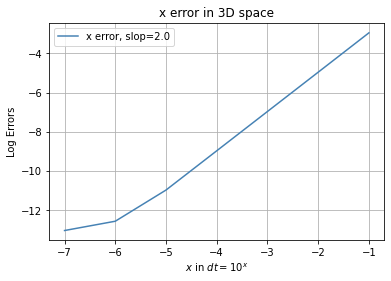

In [83]:
def get_slop(err_list):
    x_big = -1
    x_small = 0 - len(err_list) + 2
    slop = (err_list[x_big] - err_list[x_small]) / (x_big - x_small)
    return slop

new_e = list(range(decimal_place[0], decimal_place[1], -1))[::-1]
new_x_error = [log10(_) for _ in x_error[::-1]]
slop = get_slop(new_x_error)

color_list = ['', 'maroon', 'orange', 'lightgreen', 'steelblue', 'darkorchid']

x_error_h, = plt.plot(new_e, new_x_error, color=color_list[4], label=r'x error, slop=%1.1f'%slop)
plt.legend(handles=[x_error_h])
plt.title(r'x error in 3D space')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('delta_x_error.png')
plt.show()
plt.close()